<a href="https://colab.research.google.com/github/brijk7/python-docs-samples/blob/main/people-and-planet-ai/rain-nowcasting/sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
###### Licensed to the Apache Software Foundation (ASF), Version 2.0 (the "License")

# Licensed to the Apache Software Foundation (ASF) under one
# or more contributor license agreements. See the NOTICE file
# distributed with this work for additional information
# regarding copyright ownership. The ASF licenses this file
# to you under the Apache License, Version 2.0 (the
# "License"); you may not use this file except in compliance
# with the License. You may obtain a copy of the License at
#
#   http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing,
# software distributed under the License is distributed on an
# "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY
# KIND, either express or implied. See the License for the
# specific language governing permissions and limitations
# under the License.

# 🏭 Rain forecasting with satellite imagery

* **Time estimate**: 1 hour
* **Cost estimate**: less than $**5**.00 USD

This is an interactive notebook that contains all the code necessary to train an ML model from satellite images for forecasting precipitation - both the probability of rain and the amount of rainfall in the next hour. The purpose of this notebook is to be demonstrative rather than accurate.

--------------------------------------------


💚 This is one of many **machine learning how-to samples** inspired from **real climate solutions** aired on the [People and Planet AI 🎥 series](https://www.youtube.com/playlist?list=PLIivdWyY5sqI-llB35Dcb187ZG155Rs_7).

# 🚏 Overview

This notebook leverages geospatial satellite and precipitation data from [Google Earth Engine](https://earthengine.google.com/). Using satellite imagery, you'll build and train a model for rain "nowcasting" i.e. predicting the amount of rainfall for a given geospatial region and time in the immediate future.

### 🛰️ Data _(inputs)_

The data in this example consists of images from a **cloud and moisture imagery dataset** called [GOES-16](https://developers.google.com/earth-engine/datasets/catalog/NOAA_GOES_16_MCMIPF?hl=en) provided by NOAA.

When working with satellite data, each input image has the dimensions `[width, height, bands]`. **Bands** are measurements from specific satellite instruments for different ranges of the electromagnetic spectrum. The GOES-16 dataset contains [🌈 16 spectral bands](https://developers.google.com/earth-engine/datasets/catalog/NOAA_GOES_16_MCMIPF?hl=en#bands). If you're familiar with image classification problems, you can think of the bands as similar to an image's RGB channels.

In this example, we will also consider multiple images across time, since weather forecasting is more accurate when we look at how the cloud cover changes over a period of time. Particularly, we will consider 3 timepoints - 60 minutes prior, 30 minutes prior, and current - and predict rainfall for 30 minutes after. Our input dataset therefore has the shape `[timepoints, width, height, bands]`. 

### 🏷️ Labels _(outputs)_

For each geospatial location and timestamp that we provide as input to the model (as an image patch), we would like it to predict the amount of rainfall over that region in the next 30 minutes. The model would output a 2-D array of values, representing the **amount** of predicted rainfall in mm/hr for each pixel in the patch.

Known precipitation values are used as labels for model training. This label data is obtained from the Global Precipitation Map [dataset](https://developers.google.com/earth-engine/datasets/catalog/NASA_GPM_L3_IMERG_V06?hl=en).

### 🧠 Model _(function)_

The model shall take as input a cloud image patch corresponding to the location and time to forecast rain for. The image patch is extracted from Earth Engine for 3 timestamps (-60 mins, -30 mins, now). In pseudo-code:
```
predict(location, timestamp):
  region = pad(location, PADDING)
  timestamps = [timestamp-60m, timestamp-30m, timestamp]
  imagedata = earth_engine.extract(region, timestamps)
  rain_amt = model.predict(imagedata) 
```

Since the output is a continuous range of precipitation values, it is a **regression** model (as opposed to a **classification** model).

To do the above, the model must first be built by training on labeled image data. The training data is constructed by sampling small square regions of cloud imagery over several times/days of the year, and labeling them with observed precipitation values.

## 🚴‍♀️ Steps summary

Here's a quick summary of what you’ll go through:

1. **Get the training data**:
  Extract precipitation data and corresponding satellite images from [Earth Engine](https://earthengine.google.com/), and export it to
  [Cloud Storage](https://cloud.google.com/storage) in TFRecord format.

1. **Train the model with Vertex AI**:
  Using [Tensorflow Keras](https://keras.io/) on [Vertex AI Training](https://cloud.google.com/vertex-ai/docs/training/custom-training) using a [pre-built training container](https://cloud.google.com/vertex-ai/docs/training/pre-built-containers).

1. **Deploy a service to host the trained model**:
  On
  [Cloud Run](https://cloud.google.com/run)
  and get predictions using the model.

1. **Get Predictions**:
  Use the web service to get predictions for new data.

1. **Visualize predictions**:
  Visualize the predictions on a map.

1. (Optional) **Delete the project** to avoid ongoing costs.

## 🙈 Using this interactive notebook

Click the **run** icons ▶️ of each section within this notebook. 

This notebook code lets you train and deploy an ML model from end-to-end. When you run a code cell, the code runs in the notebook's runtime, so you're not making any changes to your personal computer.

> 🛎️ **To avoid any errors**, wait for each section to finish in their order before clicking the next “run” icon.

This sample must be connected to a **Google Cloud project**, but nothing else is needed other than your Google Cloud project.
You can use an existing project and the cost will be less than **$5.00**. Alternatively, you can create a new Cloud project with cloud credits for free.

# ✨ Setup

1. Decide on creating a new
   [free project](https://cloud.google.com/free/docs/gcp-free-tier)
   _(recommended)_ or using an existing one.
   Then **copy the project ID** and paste it in the `google_cloud_project` field in the "Entering project details” section below.

   > 💡 If you _don't plan to keep the resources_ that you create via this sample, we recommend creating a new project instead of selecting an existing project.
   > After you finish these steps, you can delete the project, removing all the resources associated in bulk.

1. [_Click here_](https://console.cloud.google.com/flows/enableapi?apiid=dataflow,aiplatform.googleapis.com)
   to **enable the following APIs** in your Google Cloud project:
   _Dataflow_ and _AI Platform_.

1. Make sure that **billing is enabled** for your Google Cloud project,
   [_click here_](https://cloud.google.com/billing/docs/how-to/modify-project)
   to learn how to confirm that billing is enabled.

1. Have an **Earth Engine** account (it's FREE) or create a new one.
  To create an account, fill out this [registration form](https://signup.earthengine.google.com/#!/). Please note this can take from 0-24 hours...but it's worth it! Come back to this sample after you have this.

### ⛏️ Preparing the project environment

Click the run ▶️ icons in order for the cells to download and install the necessary code, libraries, and resources for this solution.

> 💡 You can _optionally_ view the entire
> [code in GitHub](https://github.com/GoogleCloudPlatform/python-docs-samples/tree/main/people-and-planet-ai/geospatial-classification).

### ↘️ Get the code

In [ ]:
# TODO: modify to GoogleCloudPlatform
!git clone https://github.com/brijk7/python-docs-samples.git ~/pds
%cd ~/pds/people-and-planet-ai/rain-nowcasting
!pip install -r requirements.txt -c constraints.txt

### ✏️ Enter your Cloud project's details

Ensure you provide a regional Google Cloud Storage bucket! This is needed for Vertex AI.

In [1]:
#@title My Google Cloud resources
project = 'brijk-play' #@param {type:"string"}
bucket = 'brijk-ppai' #@param {type:"string"}
region = 'us-central1' #@param {type:"string"}

# Validate the inputs.
if not project:
  raise ValueError(f"Please provide a value for 'project'")
if not bucket:
  raise ValueError(f"Please provide a value for 'bucket'")
if not region:
  raise ValueError(f"Please provide a value for 'region'")

# Authenticate
from google.colab import auth

auth.authenticate_user()
print('Authenticated')

!gcloud config set project {project}

Authenticated
Updated property [core/project].


### 🗺️ Authenticate to Earth Engine

In [2]:
import ee
import google.auth
import random
import numpy as np

credentials, _ = google.auth.default()
ee.Initialize(credentials, project=project)

# 1. 🛰️ Get the training data

The training data for the model is collected by sampling the GOES-16 and GPM
datasets in Earth Engine. We will first define some global constants for convenience.

In [3]:
# Global constants

# Padding around each location in pixels
# This defines the size of the image patch that we will operate on.
GOES_PADDING = 32
GPM_PADDING = 32
PATCH_SIZE = GOES_PADDING + 1 + GOES_PADDING

# Image scale in meters
# GOES images have a raw resolution of 2000m, while GPM images are at 11132m.
# We will use 11132 to give the model a wider satellite image context.
IMAGE_SCALE = 11132

LABEL1 = 'HQprecipitation' # amount of rain in mm/hr

# 16 bands * 3 timestamps
GOES_BANDS = [f'CMI_C{i:02d}' for i in range(1,17)]
BANDS = [f'T{t}_CMI_C{i:02d}' for t in [0,1,2] for i in range(1,17)]

# We will focus on the US landmass region.
regionUSA = ee.Geometry.Polygon(
        [[[-123.1931640625, 48.15710935359644],
          [-123.1931640625, 33.05264590094408],
          [-79.68730468750002, 33.05264590094408],
          [-79.68730468750002, 48.15710935359644]]], None, False)

regionUSA = ee.Geometry.Polygon(
        [[[-125.346484375, 49.08444297902028],
          [-125.346484375, 27.43487084078891],
          [-66.63554687500002, 27.43487084078891],
          [-66.63554687500002, 49.08444297902028]]], None, False)

# Cloud and moisture satellite images from GOES-16
GOES_IMAGE_COLLECTION = ee.ImageCollection('NOAA/GOES/16/MCMIPF') \
                    .select(GOES_BANDS) \
                    .filterBounds(regionUSA)

# Precipitation images from GPM
GPM_IMAGE_COLLECTION = ee.ImageCollection('NASA/GPM_L3/IMERG_V06') \
                    .select(LABEL1) \
                    .filterBounds(regionUSA)

### 🕒 Setup timestamps for extracting data

Next, we setup a list of time points for extracting training data. The more coverage we get with different climate conditions, the better. So we will pick 1 day of each month over the last year, and 3 times during each day, for a total of 36 time points.

In [4]:
# Mid-month date for every month in 2021
dates = [f'2021-{m:02d}-15' for m in range(1,13)]

# Morning, afternoon, evening times
times = ['17:00:00', '18:30:00', '20:00:00']

# Combine them into ISO time format
training_datetimes = [d+'T'+t for d in dates for t in times]

### Fetch 🌧 labels + 🛰️ satellite image data

Our data gathering strategy would be to sample rainfall data across the US landmass region to obtain several square 64x64 regions (that we will call **patches**). We shall uniformly sample different amounts of rainfall by using the EarthEngine `ee.Image.stratifiedSample` API. This is performed in the `sample_precipitation_image` function.

For each sampled patch, we need to extract the cloud imagery at the given timepoint (as well as 2 prior timepoints over the last hour) and associate it with the precipitation map for that patch. This is performed in the `add_cloud_image_region` function.

In [5]:
def add_cloud_image_region(point: ee.Feature) -> ee.Feature:
  """Extracts a GOES image region around given geo point."""
  return goesImage.neighborhoodToArray(ee.Kernel.square(GOES_PADDING)) \
        .sampleRegions(
          collection=ee.FeatureCollection([point]), 
          scale=IMAGE_SCALE,
          geometries=True,
          ).first()

def sample_precipitation_image(image: ee.Image, 
                               location: ee.Geometry.Point = None) -> ee.FeatureCollection:
  """Samples points and add padding regions around them."""
  # Create a new property to stratify pixels by each mm/hr of rainfall from 0 to 20.
  integerPrecip = image.select(LABEL1).expression('intHQP = min(b(0), 20.0)').int()
  image = image.neighborhoodToArray(ee.Kernel.square(GPM_PADDING)) \
               .addBands(integerPrecip)

  if location:
    return image.sampleRegions(
        collection=ee.FeatureCollection([location]),
        geometries=True)
  else:
    return image.stratifiedSample(
            classBand='intHQP',
            region=regionUSA,
            numPoints=10,           # for each mm range of rainfall
            classValues=[20]*10,
            classPoints=[i for i in range(1,11)],
            geometries=True)

We bring these together by creating an orchestrating function called `extract_labeled_features` to identify and preprocess the input satellite images (for each timepoint), call upon the 2 extraction functions we defined above, and finally combine the data into a single EarthEngine `FeatureCollection`. 

In [6]:
def extract_labeled_features(timestamp: str, location: ee.Geometry.Point = None) -> ee.FeatureCollection:
  """Function to generate a list of labeled features for a given datetime.
  Each feature is of shape [3,PATCH_SIZE,PATCH_SIZE,GOES_BANDS,1].""" 
  global goesImage
  global gpmImage

  # Generate 4 timestamps: now, now-30, now-60, now+30.
  timeNow = ee.Date(timestamp)
  timeBefore30 = timeNow.advance(-30, 'minute')
  timeBefore60 = timeNow.advance(-60, 'minute')
  timeAfter30 = timeNow.advance(30, 'minute')

  # Get precipitation map for the "after 30 mins" timestamp.
  # This becomes the label that we will associate with the feature.
  gpmImage = GPM_IMAGE_COLLECTION               \
                .filterDate(timeAfter30, timeAfter30.advance(10, 'minute'))  \
                .first()
  gpmImage = gpmImage.clip(regionUSA)

  # Try masking out zero rain regions for training, 
  # to prevent the dataset from biasing heavily towards no rain data.
  #if location is None:
  #   rainMask = gpmImage.gt(1.0)
  #   gpmImage = gpmImage.updateMask(rainMask)

  features = sample_precipitation_image(gpmImage, location)

  # Extract and add cloud imagery for each of the timepoints.
  i = 0
  curBands = [LABEL1]
  for t in [timeNow, timeBefore30, timeBefore60]:
    ts = ee.Date(t)
    te = ts.advance(10, 'minute')
    trange = ee.DateRange(ts, te)

    goesImage = GOES_IMAGE_COLLECTION \
      .filterDate(trange) \
      .mosaic()
    goesImage = goesImage.clipToBoundsAndScale(geometry=regionUSA, scale=IMAGE_SCALE)
    features = features.map(add_cloud_image_region, True)

    # Rename GOES bands for this timestamp to T[i]_[BAND].
    newBands = [f'T{i}_{p}' for p in GOES_BANDS]
    features = features.select(
        GOES_BANDS + curBands, 
        newBands + curBands, 
        True)
    curBands += newBands
    i += 1

  return features

Each feature above contains a property for the precipitation label (`HQPrecipitation`), and 48 image bands, representing 16 spectral bands for 3 time points. Each property is a square array of PATCH_SIZE. Let's fetch and plot one of these features visually to get a sense of the data!

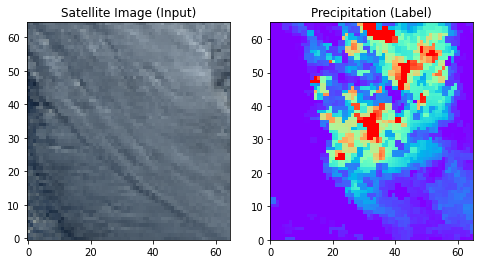

In [7]:
import matplotlib.pyplot as plt

def fetch_input_data_from_ee(lon, lat, timestamp):
  point = ee.Geometry.Point([lon, lat])
  features = extract_labeled_features(timestamp, point)
  fc = features.first().getInfo()
  input = []
  for t in ['T0','T1','T2']:
    input.append([fc['properties'][f'{t}_CMI_C{b:02d}'] for b in range(1,17)])
  input = np.array(input)
  truth = np.array(fc['properties'][LABEL1])
  return input, truth

def convert_satellite_image(array):
  BAND_SCALE_MULTIPLIER = 0.00031746001
  blue = array[0] * BAND_SCALE_MULTIPLIER
  red = array[1] * BAND_SCALE_MULTIPLIER
  veggie = array[2] * BAND_SCALE_MULTIPLIER
  green = red*0.45 + veggie*0.10 + blue*0.45
  disp = np.array([red,green,blue])
  disp = disp/0.5
  disp = np.moveaxis(disp, 0, -1)
  return disp

input_image, label_image = fetch_input_data_from_ee(-120.776171875, 38.78747076269086, '2021-12-23T17:00:00')
input_image = convert_satellite_image(input_image[0])

# Display the input and label images.
plt.figure(figsize=(8, 4))
ax = plt.subplot(1,2,1)
ax.set_title('Satellite Image (Input)')
plt.imshow(input_image, origin='lower', aspect='auto')
ax = plt.subplot(1,2,2)
ax.set_title('Precipitation (Label)')
plt.pcolormesh(label_image, cmap='rainbow', rasterized=True, vmin=0, vmax=10)
plt.show()

The top image shows the cloud and moisture imagery over a location in the San Francisco Bay Area on Dec 23rd. The bottom image shows the rainfall that occurred in that region 30 minutes after the image snapshot. Blue pixels indicate no rain, red pixels indicate rain of 10 mm/hr or more, and colors inbetween indicate values inbetween.

### 💾 Export data

Lastly, we'll export the data to a Cloud Storage bucket. We'll export the data as [TFRecords](https://www.tensorflow.org/tutorials/load_data/tfrecord). Later when we run the training job, we'll parse these TFRecords and feed them to the model.

In [28]:
gpmImage = None
goesImage = None

# Sample training data from Earth Engine.
features_list = [extract_labeled_features(t) for t in training_datetimes]
features = ee.FeatureCollection(features_list).flatten()

# Split training and validation datasets randomly.
features = features.randomColumn('random').sort('random')

# Export them to GCS.
training_task = ee.batch.Export.table.toCloudStorage(
    collection=features.filter('random <= 0.75'),
    description='Nowcasting training data export',
    bucket=bucket,
    fileNamePrefix='nowcasting/training',
    fileFormat='TFRecord'
)
training_task.start()

validation_task = ee.batch.Export.table.toCloudStorage(
    collection=features.filter('random > 0.75'),
    description='Nowcasting validation data export',
    bucket=bucket,
    fileNamePrefix='nowcasting/validation',
    fileFormat='TFRecord'
)
validation_task.start()

This export will take about 20-30 minutes. You can monitor progress at this link: https://code.earthengine.google.com/tasks.

Once both tasks show COMPLETED, verify that the data files are in the GCS bucket:

In [ ]:
!gsutil ls -lh gs://{bucket}/nowcasting

# 2. 🧠 Train the ML model 

Now we're **ready to use** that data to train a model. We will train our model as a batch job in Vertex AI. 

We have the model building and training code in the file task.py. Feel free to peruse the code. Some salient points:

*  uses the TensorFlow and Keras API
*  reads the saved datasets using the `TFRecordDataset` API
*  builds a sequential deep neural network model with a few convolutional layers
*  saves the model to the GCS bucket under the model/ subfolder

This next step schedules a job in Vertex AI to execute task.py. It may take about 10 minutes to run.

In [ ]:
from google.cloud import aiplatform

aiplatform.init(project=project, staging_bucket=bucket)

job = aiplatform.CustomTrainingJob(
    display_name="nowcasting_model_training",
    script_path="task.py",
    container_uri="us-docker.pkg.dev/vertex-ai/training/tf-cpu.2-7:latest")

model = job.run(args=[f'--bucket={bucket}'])

# 3. 🔮 Make predictions

Let's use the model we just built to make weather predictions on some satellite imagery! Will it rain or not rain? How much rainfall do we expect? Let's ask our shiny new model.   

First, let's load the model from GCS and see its architecture.

In [8]:
import tensorflow as tf
model = tf.keras.models.load_model(f'gs://{bucket}/nowcasting/model')
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3, 65, 65, 16)]   0         
                                                                 
 normalization (Normalizatio  (None, 3, 65, 65, 16)    33        
 n)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 3, 65, 65, 32)    4640      
 ibuted)                                                         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 1, 65, 65, 32)    0         
 )                                                               
                                                                 
 reshape (Reshape)           (None, 65, 65, 32)        0         
                                                             

Let's setup some test data to predict rainfall for!

In [9]:
# Setup some test data to predict   
test_data = [
             ['2021-12-23T17:00:00', -118.04194946289063, 40.788608828924076, 'light rain'],    
             ['2021-12-15T17:30:00', -76.23759765625002, 43.16430423079589, 'medium rain'],          
             ['2021-12-23T17:00:00', -119.66792602539063, 36.882018532995076, 'heavy rain'],    
             ['2021-12-23T17:00:00', -112.0310546875, 36.27880268550452, 'just cloudy'],         
             ['2021-09-23T17:00:00', -119.98515625, 39.68941717505306, 'clear'],           
             ['2021-11-15T17:30:00', -123.72188110351563, 45.6445363447774, 'medium rain'],         
             ['2021-12-23T17:00:00', -115.70048828125, 35.324365287778654, 'light rain']]     

Now we are ready to execute the model on the test data and get some predictions.

In [10]:
test_inputs = []
test_truths = []
test_preds = []

for timestamp, lon, lat, title in test_data:
  input, truth = fetch_input_data_from_ee(lon, lat, timestamp)
  if input is None or truth is None:
    test_inputs.append(None)
    test_truths.append(None)
    test_preds.append(None)
    print(f'Empty input fetched from EarthEngine for {lon},{lat}. Skipping!')
    continue

  test_inputs.append(input)
  test_truths.append(truth)
  
  # Transform [3,BANDS,PATCH,PATCH] input to [3,PATCH,PATCH,BANDS].
  input = np.moveaxis(input, 1, 3)  
  input = np.expand_dims(input, axis=0)
  pred = model.predict(input)

  # Squeeze [1,PATCH,PATCH,1] output to [PATCH,PATCH].
  pred = np.squeeze(pred, axis=0)
  pred = np.squeeze(pred, axis=-1)
  #pred = np.argmax(pred, axis=-1)*1.0
  pred = pred*10.0
  test_preds.append(pred)

  pred_avg_rain = np.average(pred)
  truth_avg_rain = np.average(truth)
  print(f'Average rain: truth: {truth_avg_rain:.2f}; predicted: {pred_avg_rain:.2f}')

Average rain: truth: 1.06; predicted: 0.40
Average rain: truth: 1.09; predicted: 1.10
Average rain: truth: 2.34; predicted: 0.43
Average rain: truth: 0.03; predicted: 0.08
Average rain: truth: 0.00; predicted: 0.01
Average rain: truth: 2.61; predicted: 0.53
Average rain: truth: 0.30; predicted: 0.11


# 4. 🗺️ Visualize predictions

Now that we have truths and predictions, let's plot them as images and see how they compare! The top row are band-composited satellite input images, the second row are precipitation truth values (red pixels indicate higher rain), and the bottom row are predictions from the model.

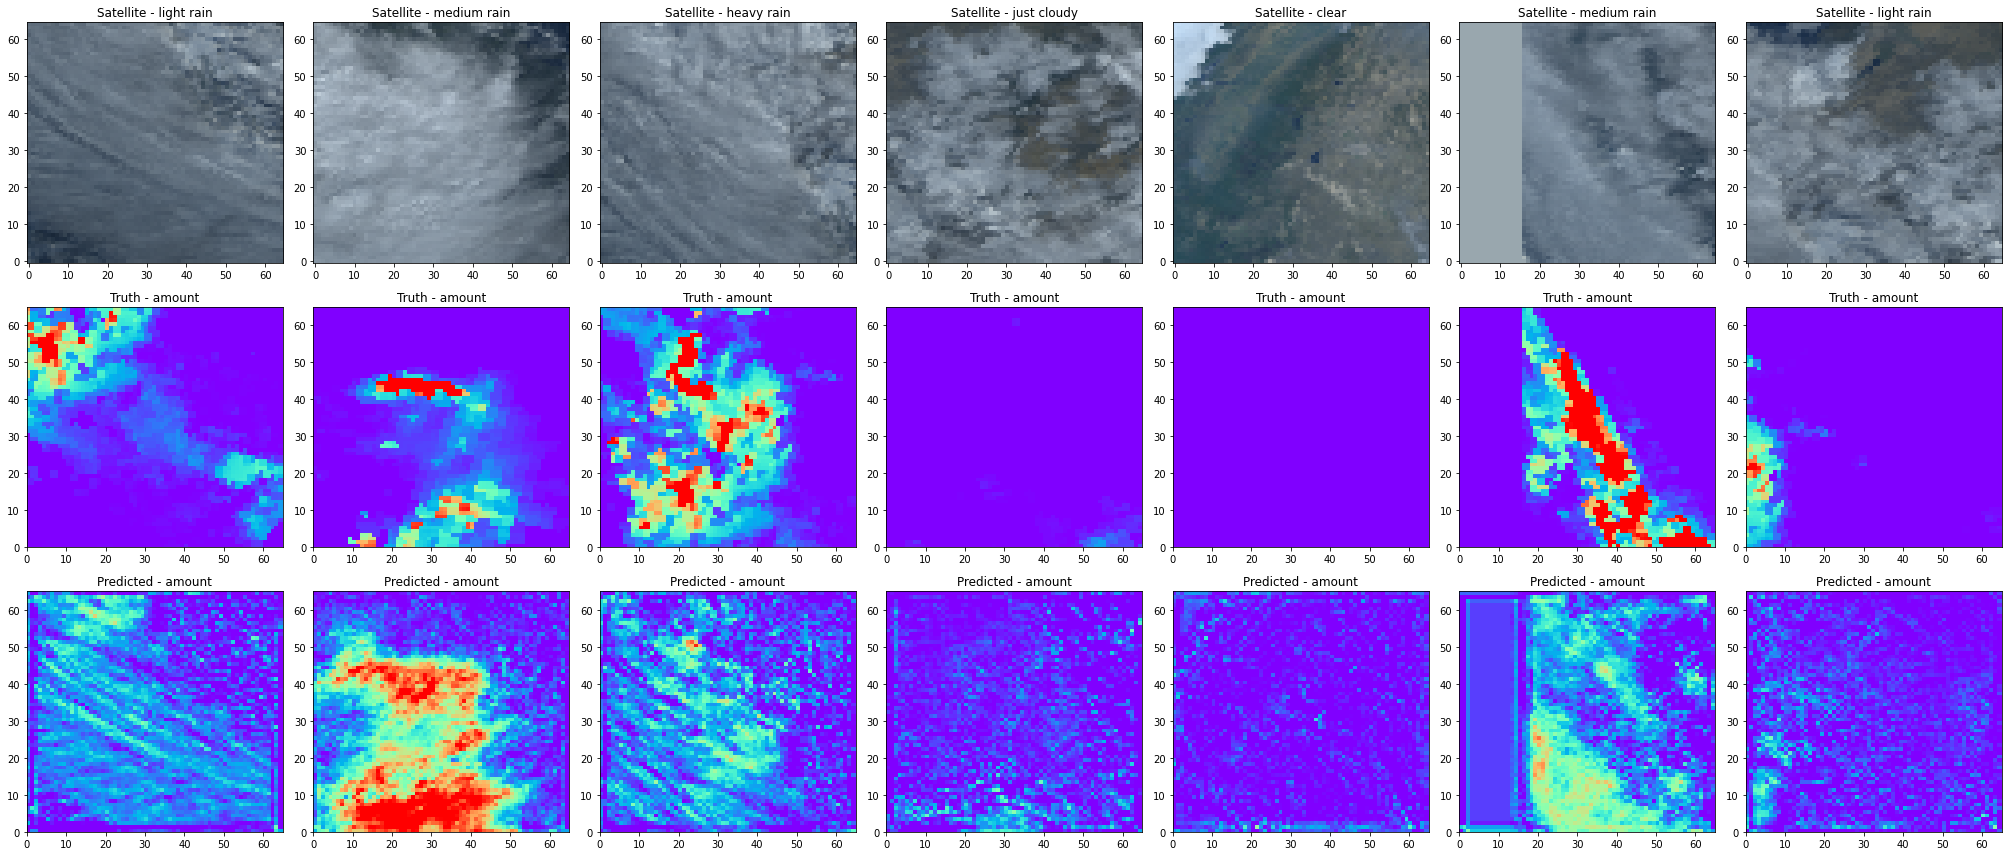

In [11]:
# Setup a 3 row plot grid.
n = len(test_truths)
fig = plt.figure(figsize=(n*4, 12))
i = 1

for input, truth, pred in zip(test_inputs, test_truths, test_preds):
  if input is None:
    i += 1
    continue
  title = test_data[i-1][3]
  # input satellite image
  ax = plt.subplot(3,n,i)
  ax.set_title('Satellite - ' + title)
  input_disp = convert_satellite_image(input[0])
  plt.imshow(input_disp, origin='lower', aspect='auto')
  # rain amount - LABEL1
  ax = plt.subplot(3,n,i+n)
  ax.set_title('Truth - amount')
  plt.pcolormesh(truth, cmap='rainbow', rasterized=True, vmin=0, vmax=10)
  ax = plt.subplot(3,n,i+n+n)
  ax.set_title('Predicted - amount')
  plt.pcolormesh(pred, cmap='rainbow', rasterized=True, vmin=0, vmax=3)
  i += 1

plt.tight_layout()
plt.show()

# 5. ⛵ Further exploration

This notebook demonstrated a simple model to start exploring the problem of weather forecasting using deep neural networks. The model has less than 100k parameters and only a few Conv2D layers to keep training time short. Even so, the model is able to distinguish cloud patterns for broad rain vs no rain detection. 

There has been a lot of interesting research work on weather nowcasting recently, especially with [U-Net](https://en.wikipedia.org/wiki/U-Net) style model architectures. If you are interested in diving deeper, here are some articles from Google Research: 

*  [Google Research blog on nowcasting](https://ai.googleblog.com/2021/11/metnet-2-deep-learning-for-12-hour.html)
*  [MetNet paper](https://arxiv.org/abs/2003.12140)

# 6. 🧹 Clean Up

To **avoid incurring charges** to your Google Cloud account for the resources used in this tutorial, either delete the project that contains the resources, or keep the project and delete the individual resources.

## Deleting the project

The **easiest** way to **eliminate billing** is to delete the project that you created for the tutorial.

To delete the project:

> ⚠️ Deleting a project has the following effects:
>
> * **Everything in the project is deleted.** If you used an existing project for this tutorial, when you delete it, you also delete any other work you've done in the project.
>
> * **Custom project IDs are lost.** When you created this project, you might have created a custom project ID that you want to use in the future. To preserve the URLs that use the project ID, such as an appspot.com URL, delete selected resources inside the project instead of deleting the whole project.
>
> If you plan to explore multiple tutorials and quickstarts, **reusing** projects can help you avoid exceeding project **quota limits**.

1. In the Cloud Console, go to the **Manage resources** page.

  <button>

  [Go to Manage resources](https://console.cloud.google.com/iam-admin/projects)

  </button>

1. In the project list, select the project that you want to delete, and then click **Delete**.

1. In the dialog, type the project ID, and then click **Shut down** to delete the project.